# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [1]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math

In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.set_printoptions(precision=3, sci_mode=True)

## ======================== Parameters ========================
d1 = 100                   # num. of rows
d2 = 70                   # num. of columns
max_iter = 100              # num. of layers trained
r = 2
alpha = 0.3

In [3]:
## Code to generate data for RPCA problem. References:
## https://github.com/caesarcai/LRPCA/blob/main/synthetic_data_exp/training_codes.py 
## https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/test_AccAltProj.m

def generate_problem(r,d1,d2,alpha, c):
    U0_t 		= torch.randn(d1,r)
    V0_t 		= torch.randn(d2,r)
    L0_t 		= U0_t @ V0_t.t()
    idx 		= torch.randperm(d1*d2)
    idx 		= idx[:math.floor(alpha * d1*d2)]
    s_range		= c * torch.mean(torch.abs(L0_t))
    S0_tmp 		= torch.rand(d1 * d2)
    S0_tmp 		= s_range * (2.0 * S0_tmp - 1.0)
    S0_t        = torch.zeros(d1 * d2)
    S0_t[idx]   = S0_tmp[idx]
    S0_t        = S0_t.reshape((d1,d2))
    Y0_t        = L0_t + S0_t
    return L0_t, S0_t, Y0_t

## Classical

In [38]:
def thres(inputs, threshold, hard=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- threshold, torch.zeros([1,1]))
    else:
        out = inputs * (torch.abs(inputs) > threshold)
    return out

def AccAltProj(M0, r, tol, gamma, max_iter):
    m, n = M0.shape
    norm_of_M0 = torch.linalg.norm(M0)
    ## Keep track of loss
    loss = []
    ## Initialization
    beta = 1/(2 * np.power(m * n, 1/4))
    beta_init = 4 * beta
    zeta = beta_init * torch.linalg.norm(M0, 2)
    S = thres(M0, zeta)#, False)
    U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
    ## NOTE: torch.linalg.svd(M) returns U, S, V such that M=USV not USV.T
    U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
    L = U @ torch.diag(Sigma) @ V.t()
    zeta = beta * Sigma[0]
    S = thres(M0 - L, zeta)#, False)
    ## Initial loss
    err = torch.linalg.norm(M0 - L - S)/ norm_of_M0
    loss.append(err)
    for t in range(max_iter):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sigma, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sigma[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sigma[r] + torch.pow(gamma, t + 1) * Sigma[0])
        S = thres(M0 - L, zeta)#, False)
        ## Compute error
        err = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        loss.append(err)
        if err < tol:
            return loss, L, S
    return loss, L, S

In [39]:
## generate data
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha, c=1)

In [40]:
## start with M_true, assuming known rank
## error tolerance = 1e-6, gamma = 0.5, max_iter = 100
loss, L_hat, S_hat = AccAltProj(M_true, r, 1e-6, torch.tensor(0.7), max_iter)

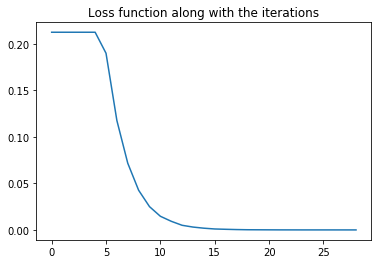

tensor(8.122e-07)
tensor(1.233e-06)
tensor(1.324e-05)


In [41]:
plt.plot(loss)
plt.title('Loss function along with the iterations')
plt.show()

print(loss[-1])
print(torch.linalg.norm(L_hat - L_true)/ torch.linalg.norm(L_true))
print(torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

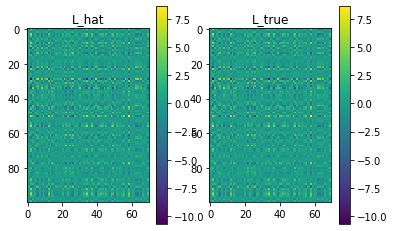

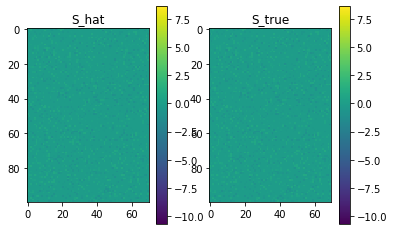

In [42]:
combined = torch.cat((L_hat, L_true, S_hat, S_true)) ## combine matrices so that colorbars can be standardized

fig, [ax1, ax2] = plt.subplots(1,2)
im1 = ax1.imshow(L_hat, vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("L_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(L_true, vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("L_true")
plt.colorbar(im2, ax=ax2)
plt.show()

fig, [ax1, ax2] = plt.subplots(1,2)
im1 = ax1.imshow(S_hat, vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("S_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(S_true, vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("S_true")
plt.colorbar(im2, ax=ax2)
plt.show()

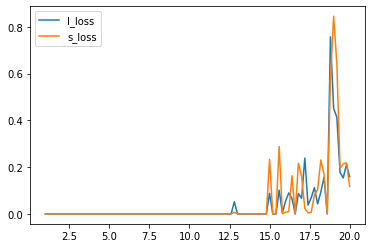

In [43]:
## Non-zero entries of sparse component S are drawn i.i.d. from the uniform distribution
## over the interval [-c*E(|[L]_ij|), c*E(|[L]_ij|)] for some constant c > 0.
## This part is just looking at how c affects the approximation of L and S in this algorithm.
con = np.arange(1,20.2,0.2)
l_loss = []
s_loss = []
for c in con:
    L0, S0, M0 = generate_problem(2, 100, 70, alpha, c)
    loss, L1, S1 = AccAltProj(M0, r, 1e-6, torch.tensor(0.7), 100)
    l_loss.append(torch.linalg.norm(L0 - L1)/ torch.linalg.norm(L0))
    s_loss.append(torch.linalg.norm(S0 - S1, 1)/ torch.linalg.norm(S0, 1))
plt.plot(con, l_loss, label = "l_loss")
plt.plot(con, s_loss, label = "s_loss")
plt.legend()
plt.show()

## Unrolled version

In [75]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = torch.sign(M0) * torch.max(torch.abs(M0)- zeta, torch.zeros([1,1]))
        # S = M0 * (torch.abs(M0) > zeta)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = torch.sign(S) * torch.max(torch.abs(S)- zeta, torch.zeros([1,1]))
        # S = S * (torch.abs(S) > zeta)
        return S, L, U, V, beta, norm_of_M0
class ProjStage(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
    def forward(self, M0, S, U, V, r, beta, g):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        g = self.gamma * g
        zeta = beta * (Sm[r] + g * Sm[0])
        S = M0 - L
        S = torch.sign(S) * torch.max(torch.abs(S)- zeta, torch.zeros([1,1]))
        # S = S * (torch.abs(S) > zeta)
        return S, L, U, V, g

class LearnedAAP(nn.Module):
    def __init__(self, max_iter, gamma):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = gamma
        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.loss = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        g = torch.tensor(1.0)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V, g = lay(M0, S, U, V, r, beta, g)
            self.loss[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

In [76]:
np.random.seed(0)
torch.manual_seed(0)

## ======================== Parameters ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
r = 2

In [77]:
## generate data
alpha_true = 0.3 # np.random.normal(0.5, 0.25)
c_true = 1 # np.random.normal(3, 2.5)
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha_true, c_true)

In [7]:
print(alpha_true, c_true)

0.3 1


In [78]:
## ======================== Training ========================
net = LearnedAAP(max_iter, gamma=torch.tensor(0.7))
L_bftrain, S_bftrain = net(M_true, r) # assumes knowledge of rank
lossbftrain=np.array(net.loss)
params_bftrain = [x.clone().detach().numpy() for x in list(net.parameters())]

In [79]:
#optimizer=SGD(net.parameters(), lr=1e-5, weight_decay=1e-2) # Adam algorithm will be learned to optimise paramaters
optimizer=Adam(net.parameters(), lr=1e-5, weight_decay=1e-2)

nepochs = 50

for epoch in range(nepochs):

    for i in range(50): ## 50 training samples
        alpha = alpha_true # np.random.normal(0.5, 0.25)
        c = c_true # np.random.normal(3, 2.5)
        L0, S0, M0 = generate_problem(r, d1, d2, alpha, c)
        optimizer.zero_grad()
        L_hat, S_hat = net(M0, r)
        # loss = torch.linalg.norm(M0 - L_hat - S_hat)/ torch.linalg.norm(M0)
        loss = (1/2)*torch.linalg.norm(L0 - L_hat)/torch.linalg.norm(L0) \
                + (1/2)*torch.linalg.norm(S0 - S_hat)/torch.linalg.norm(S0) \
                + torch.linalg.norm(M0 - L_hat - S_hat)/ torch.linalg.norm(M0)
        loss.backward()
        ## ^ error encountered at this step when hard-thresholding is used instead of soft-thresholding
        ## RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
        optimizer.step()
    print(list(net.parameters()))
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))

print('Finished Training')

[Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
tensor(6.995e-01, requires_grad=True), Parameter containing:
t

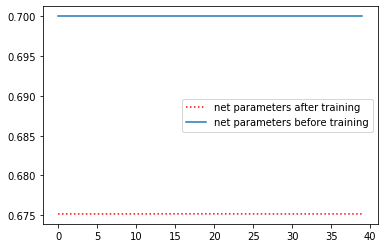

In [80]:
## plot learned parameters
plt.plot([x.detach().numpy() for x in list(net.parameters())],'r:',label='net parameters after training')
plt.plot(params_bftrain, label='net parameters before training')
plt.legend()
plt.show()

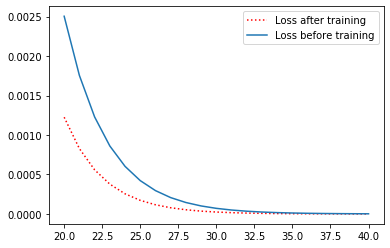

Before train
||L - L_hat||F: tensor(7.264e-07, grad_fn=<DivBackward0>)
||S - S_hat||1: tensor(1.072e-05, grad_fn=<DivBackward0>)
After train
||L - L_hat||F: tensor(3.106e-07, grad_fn=<DivBackward0>)
||S - S_hat||1: tensor(4.906e-06, grad_fn=<DivBackward0>)


In [81]:
L_hat, S_hat = net(M_true, r)
plt.plot(range(max_iter+1)[20:],np.array(net.loss)[20:],'r:',label='Loss after training')
plt.plot(range(max_iter+1)[20:],lossbftrain[20:],label='Loss before training')
plt.legend()
plt.show()
print("Before train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_bftrain)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_bftrain, 1)/ torch.linalg.norm(S_true, 1))
print("After train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))

In [82]:
print("Before train: ", lossbftrain[-1])
print("After train: ", net.loss[-1])

Before train:  2.0151978787907865e-06
After train:  5.020498861085798e-07


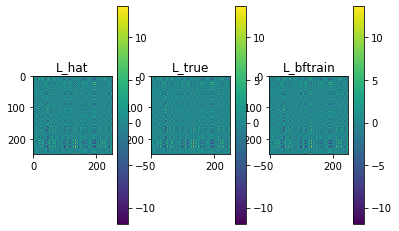

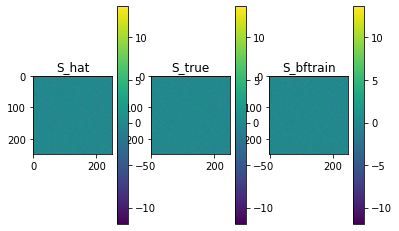

In [83]:
combined = torch.cat((L_hat, L_true, S_hat, S_true)) ## combine matrices so that colorbars can be standardized

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
im1 = ax1.imshow(L_hat.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("L_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(L_true.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("L_true")
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(L_bftrain.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax3.set_title("L_bftrain")
plt.colorbar(im3, ax=ax3)
plt.show()

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
im1 = ax1.imshow(S_hat.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("S_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(S_true.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("S_true")
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(S_bftrain.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax3.set_title("S_bftrain")
plt.colorbar(im3, ax=ax3)
plt.show()

## when dimension of matrix is large (2500 x 2500)

In [339]:
np.random.seed(0)
torch.manual_seed(0)

## ======================== Parameters ========================
d1 = 2500                   # num. of rows
d2 = 2500                   # num. of columns
max_iter = 40              # num. of layers trained
r = 5
## generate data
alpha_true = 0.3
c_true = 1
L_true, S_true, M_true = generate_problem(r, d1, d2, alpha_true, c_true)
## ======================== Training ========================
net = LearnedAAP(max_iter, gamma=torch.tensor(0.7))
L_bftrain, S_bftrain = net(M_true, r) # assumes knowledge of rank
lossbftrain=np.array(net.loss)
params_bftrain = [x.clone().detach().numpy() for x in list(net.parameters())]

In [340]:
optimizer=Adam(net.parameters(), lr=1e-5, weight_decay=1e-2)

nepochs = 10

for epoch in range(nepochs):

    for i in range(10):
        alpha = alpha_true
        c = c_true
        L0, S0, M0 = generate_problem(r, d1, d2, alpha, c)
        optimizer.zero_grad()
        L_hat, S_hat = net(M0, r)
        loss = torch.linalg.norm(M0 - L_hat - S_hat)/ torch.linalg.norm(M0)
        loss.backward()
        for name, param in net.named_parameters():
            if not torch.isfinite(param.grad).all():
                print(name, torch.isfinite(param.grad).all())
                break
        optimizer.step()
    #print(list(net.parameters()))
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))

print('Finished Training')

Epoch 1/10 at cost=1.802923907234799e-05
Epoch 2/10 at cost=3.4924494684673846e-05
Epoch 3/10 at cost=1.961456291610375e-05
Epoch 4/10 at cost=1.0173925147682894e-05
Epoch 5/10 at cost=1.047662317432696e-05
Epoch 6/10 at cost=2.7140318707097322e-05
Epoch 7/10 at cost=1.668195181991905e-05
Epoch 8/10 at cost=2.942474566225428e-05
Epoch 9/10 at cost=7.159218057495309e-06
Epoch 10/10 at cost=1.215907650475856e-05
Finished Training


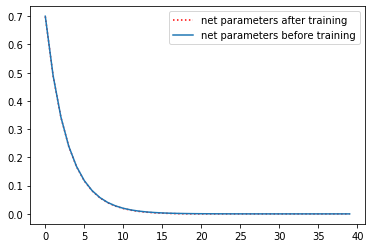

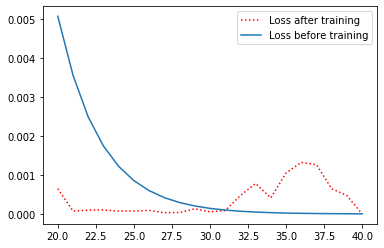

Before train
||L - L_hat||F: tensor(8.392e-07, grad_fn=<DivBackward0>)
||S - S_hat||1: tensor(2.008e-05, grad_fn=<DivBackward0>)
After train
||L - L_hat||F: tensor(1.829e-03, grad_fn=<DivBackward0>)
||S - S_hat||1: tensor(1.788e-02, grad_fn=<DivBackward0>)
Before train:  4.080639428138966e-06
After train:  1.8593898403196363e-06


In [341]:
## plot learned parameters
plt.plot([x.detach().numpy() for x in list(net.parameters())],'r:',label='net parameters after training')
plt.plot(params_bftrain, label='net parameters before training')
plt.legend()
plt.show()
L_hat, S_hat = net(M_true, r)
plt.plot(range(max_iter+1)[20:],np.array(net.loss)[20:],'r:',label='Loss after training')
plt.plot(range(max_iter+1)[20:],lossbftrain[20:],label='Loss before training')
plt.legend()
plt.show()
print("Before train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_bftrain)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_bftrain, 1)/ torch.linalg.norm(S_true, 1))
print("After train")
print("||L - L_hat||F:", torch.linalg.norm(L_true - L_hat)/ torch.linalg.norm(L_true))
print("||S - S_hat||1:", torch.linalg.norm(S_true - S_hat, 1)/ torch.linalg.norm(S_true, 1))
print("Before train: ", lossbftrain[-1])
print("After train: ", net.loss[-1])

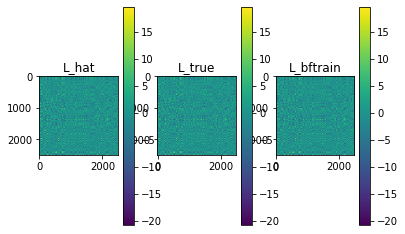

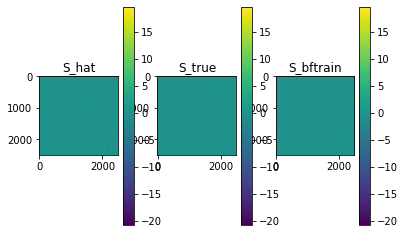

In [342]:
combined = torch.cat((L_hat, L_true, S_hat, S_true)) ## combine matrices so that colorbars can be standardized

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
im1 = ax1.imshow(L_hat.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("L_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(L_true.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("L_true")
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(L_bftrain.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax3.set_title("L_bftrain")
plt.colorbar(im3, ax=ax3)
plt.show()

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
im1 = ax1.imshow(S_hat.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax1.set_title("S_hat")
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(S_true.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax2.set_title("S_true")
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(S_bftrain.detach().numpy(), vmin=torch.min(combined), vmax = torch.max(combined))
ax3.set_title("S_bftrain")
plt.colorbar(im3, ax=ax3)
plt.show()